<a href="https://colab.research.google.com/github/phoenix30coder/TNSDCGENAI/blob/main/Stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Flatten, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [13]:
# Load data
data_path = "S&P500.csv"
dataframe = pd.read_csv(data_path)

In [14]:
# Add moving average column
dataframe['Ma'] = dataframe['Close'].rolling(window=5).mean()

In [15]:
# Drop NA values
dataframe.dropna(inplace=True)

In [16]:
# Normalize data
data = dataframe.drop(columns=['Date']).values

data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [17]:
# Parameters
n_sequence = 10
n_features = data.shape[1]
n_batch = 32
train_size = int(len(data) * 0.9)
len(data)

5027

In [18]:
# Prepare data
def create_dataset(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [19]:
X, y = create_dataset(data, n_sequence)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [20]:
# Generator
def build_generator():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(n_sequence, n_features)))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(n_features))
    return model

In [21]:
# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(n_sequence + 1, n_features)))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
generator = build_generator()
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [23]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,911 (202.78 KB)

 Trainable params: 51,911 (202.78 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 77)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,217 (36.00 KB)

 Trainable params: 9,217 (36.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Combined GAN
discriminator.trainable = False
gan_input = Input(shape=(n_sequence, n_features))
generated_data = generator(gan_input)

# Wrap tf.concat in a Lambda layer
gan_output = discriminator(tf.keras.layers.Lambda(lambda x: tf.concat([x[0], tf.expand_dims(x[1], axis=1)], axis=1))([gan_input, generated_data]))

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [26]:
def train_gan(X_train, y_train, epochs, batch_size):
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_seqs = X_train[idx]
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        generated_data = generator.predict(real_seqs)
        fake_seqs = np.concatenate([real_seqs, np.expand_dims(generated_data, axis=1)], axis=1)
        real_seqs = np.concatenate([real_seqs, np.expand_dims(y_train[idx], axis=1)], axis=1)

        d_loss_real = discriminator.train_on_batch(real_seqs, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_seqs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        misleading_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(real_seqs[:, :-1], misleading_labels)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Discriminator Loss: {d_loss[0]} - Generator Loss: {g_loss}")

train_gan(X_train, y_train, epochs=100, batch_size=n_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


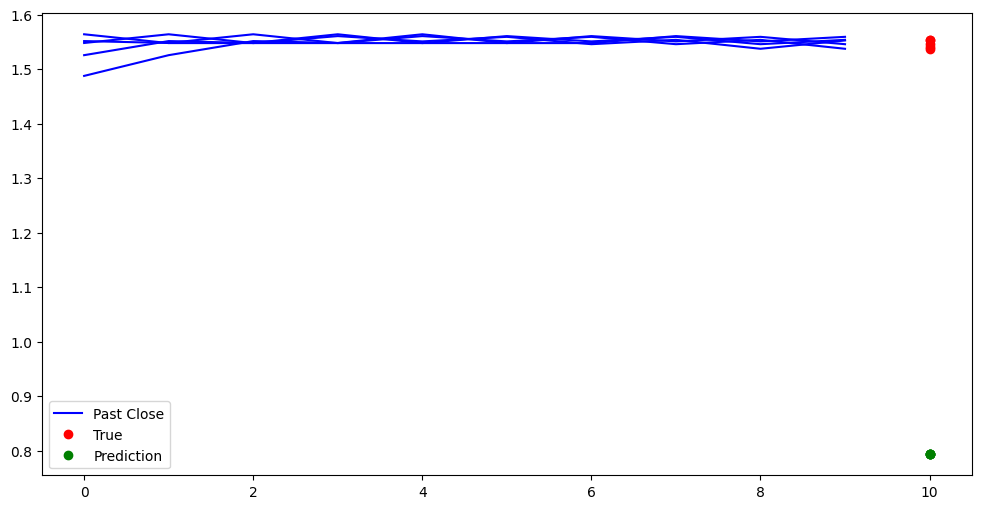

In [27]:
def plot_predictions(X_test, y_test, generator, n_samples=5):
    predictions = generator.predict(X_test)
    plt.figure(figsize=(12, 6))
    for i in range(n_samples):
        plt.plot(range(n_sequence), X_test[i, :, 3], 'b', label='Past Close' if i == 0 else "")
        plt.plot(n_sequence, y_test[i, 3], 'ro', label='True' if i == 0 else "")
        plt.plot(n_sequence, predictions[i, 3], 'go', label='Prediction' if i == 0 else "")
    plt.legend()
    plt.show()

plot_predictions(X_test, y_test, generator)


In [28]:
# Load data
dataframe = pd.read_csv(data_path)

# Add moving average column
dataframe['Ma'] = dataframe['Close'].rolling(window=5).mean()

# Drop NA values
dataframe.dropna(inplace=True)

# Normalize data
data = dataframe.drop(columns=['Date']).values
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Get the most recent sequence
recent_sequence = data[-n_sequence:]
recent_sequence = np.expand_dims(recent_sequence, axis=0)


In [29]:
# Predict the next data point
predicted_data = generator.predict(recent_sequence)

# Denormalize the predicted data
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
predicted_data_denormalized = predicted_data * std + mean

# Display the predicted result
print("Predicted data for today:")
labels = dataframe.columns[1:]
print(predicted_data_denormalized)
for label, value in zip(labels, predicted_data_denormalized[0]):
    print(f"{label}: {value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted data for today:
[[ 0.11004252 -0.56847495 -0.14424923  0.78276867 -0.63967568 -0.24508056
   0.10667476]]
Open: 0.11004251986742042
High: -0.5684749484062197
Low: -0.14424923062324532
Close: 0.7827686667442324
Adj Close: -0.6396756768226621
Volume: -0.24508056044578552
Ma: 0.1066747605800625


In [30]:
# prompt: save the above trained  model all generator and descrimnator

# Save the generator
generator.save('generator_model.h5')

# Save the discriminator
discriminator.save('discriminator_model.h5')


In [35]:
#Tkinter APP

In [36]:
from tensorflow.keras.models import load_model

# Load the pre-trained generator model
model = load_model('generator_model.h5')


In [38]:
print(tf.__version__)

2.17.0


In [41]:
predicted_data= model.predict(recent_sequence)

# Denormalize the predicted data
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
predicted_data_denormalized = predicted_data * std + mean

# Display the predicted result
print("Predicted data for today:",len(recent_sequence))
labels = dataframe.columns[1:]
print(predicted_data_denormalized)
for label, value in zip(labels, predicted_data_denormalized[0]):
    print(f"{label}: {value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted data for today: 1
[[1.55059290e+03 1.22016654e+03 1.41412863e+03 1.88673617e+03
  1.17625300e+03 2.57778035e+09 1.54849024e+03]]
Open: 1550.5928966499016
High: 1220.1665441101086
Low: 1414.1286258967489
Close: 1886.7361728580518
Adj Close: 1176.2530014354795
Volume: 2577780351.1177344
Ma: 1548.4902397168744
